# Jacobi Eigenvalue Algorithm

## Introduction

The **Jacobi eigenvalue algorithm** is an iterative method for computing the eigenvalues and eigenvectors of a real symmetric matrix. Developed by Carl Gustav Jacob Jacobi in 1846, it remains one of the most elegant and numerically stable methods for solving the symmetric eigenvalue problem.

## Mathematical Foundation

### The Eigenvalue Problem

Given a real symmetric matrix $A \in \mathbb{R}^{n \times n}$, we seek to find eigenvalues $\lambda_i$ and eigenvectors $\mathbf{v}_i$ such that:

$$A\mathbf{v}_i = \lambda_i \mathbf{v}_i$$

For symmetric matrices, all eigenvalues are real, and eigenvectors corresponding to distinct eigenvalues are orthogonal.

### Jacobi Rotation Matrices

The Jacobi method works by applying a sequence of orthogonal similarity transformations (Jacobi rotations) to systematically eliminate off-diagonal elements. A Jacobi rotation matrix $J(p, q, \theta)$ is an identity matrix modified at four positions:

$$J_{pp} = J_{qq} = \cos\theta$$
$$J_{pq} = -J_{qp} = \sin\theta$$

This represents a rotation by angle $\theta$ in the $(p, q)$ plane.

### Computing the Rotation Angle

To eliminate element $a_{pq}$, we choose $\theta$ such that the transformed matrix $A' = J^T A J$ has $a'_{pq} = 0$. This requires:

$$\cot(2\theta) = \tau = \frac{a_{qq} - a_{pp}}{2a_{pq}}$$

From this, we compute:

$$t = \tan\theta = \frac{\text{sign}(\tau)}{|\tau| + \sqrt{1 + \tau^2}}$$

$$c = \cos\theta = \frac{1}{\sqrt{1 + t^2}}, \quad s = \sin\theta = tc$$

### Convergence

The algorithm minimizes the Frobenius norm of the off-diagonal elements:

$$\text{off}(A) = \sqrt{\sum_{i \neq j} a_{ij}^2}$$

Each rotation reduces this quantity, and the process converges when $\text{off}(A) < \epsilon$ for a chosen tolerance $\epsilon$.

## Algorithm Variants

1. **Classical Jacobi**: Eliminates the largest off-diagonal element at each step
2. **Cyclic Jacobi**: Sweeps through elements in a fixed order
3. **Threshold Jacobi**: Only rotates elements above a decreasing threshold

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

np.random.seed(42)

## Implementation

We implement the classical Jacobi algorithm that selects the largest off-diagonal element at each iteration.

In [2]:
def jacobi_rotation(A, p, q):
    """
    Compute a single Jacobi rotation to eliminate element A[p,q].
    
    Parameters:
    -----------
    A : ndarray
        Symmetric matrix to be transformed
    p, q : int
        Indices of the off-diagonal element to eliminate (p < q)
    
    Returns:
    --------
    c, s : float
        Cosine and sine of the rotation angle
    """
    if A[p, q] == 0:
        return 1.0, 0.0
    
    tau = (A[q, q] - A[p, p]) / (2 * A[p, q])
    
    # Choose the smaller root for numerical stability
    if tau >= 0:
        t = 1.0 / (tau + np.sqrt(1 + tau**2))
    else:
        t = -1.0 / (-tau + np.sqrt(1 + tau**2))
    
    c = 1.0 / np.sqrt(1 + t**2)
    s = t * c
    
    return c, s


def apply_jacobi_rotation(A, V, p, q, c, s):
    """
    Apply Jacobi rotation to matrix A and accumulate in eigenvector matrix V.
    
    This computes A' = J^T A J where J is the rotation matrix.
    """
    n = A.shape[0]
    
    # Update columns/rows p and q of A
    for i in range(n):
        if i != p and i != q:
            a_ip = A[i, p]
            a_iq = A[i, q]
            A[i, p] = c * a_ip - s * a_iq
            A[p, i] = A[i, p]
            A[i, q] = s * a_ip + c * a_iq
            A[q, i] = A[i, q]
    
    # Update diagonal and off-diagonal elements at (p,p), (q,q), (p,q)
    a_pp = A[p, p]
    a_qq = A[q, q]
    a_pq = A[p, q]
    
    A[p, p] = c**2 * a_pp - 2 * s * c * a_pq + s**2 * a_qq
    A[q, q] = s**2 * a_pp + 2 * s * c * a_pq + c**2 * a_qq
    A[p, q] = 0.0
    A[q, p] = 0.0
    
    # Accumulate eigenvectors
    for i in range(n):
        v_ip = V[i, p]
        v_iq = V[i, q]
        V[i, p] = c * v_ip - s * v_iq
        V[i, q] = s * v_ip + c * v_iq


def off_diagonal_norm(A):
    """
    Compute the Frobenius norm of off-diagonal elements.
    """
    n = A.shape[0]
    off_sum = 0.0
    for i in range(n):
        for j in range(i + 1, n):
            off_sum += 2 * A[i, j]**2
    return np.sqrt(off_sum)


def find_max_off_diagonal(A):
    """
    Find the indices of the largest off-diagonal element.
    """
    n = A.shape[0]
    max_val = 0.0
    p, q = 0, 1
    
    for i in range(n):
        for j in range(i + 1, n):
            if abs(A[i, j]) > max_val:
                max_val = abs(A[i, j])
                p, q = i, j
    
    return p, q

In [3]:
def jacobi_eigenvalue(A, tol=1e-10, max_iter=1000):
    """
    Compute eigenvalues and eigenvectors using the Jacobi algorithm.
    
    Parameters:
    -----------
    A : ndarray
        Real symmetric matrix
    tol : float
        Convergence tolerance for off-diagonal norm
    max_iter : int
        Maximum number of iterations
    
    Returns:
    --------
    eigenvalues : ndarray
        Array of eigenvalues (diagonal of final matrix)
    eigenvectors : ndarray
        Matrix of eigenvectors (columns)
    history : dict
        Convergence history including off-diagonal norms
    """
    n = A.shape[0]
    
    # Work with a copy
    A = A.copy().astype(float)
    
    # Initialize eigenvector matrix as identity
    V = np.eye(n)
    
    # Track convergence
    history = {
        'off_diagonal_norm': [],
        'iterations': 0,
        'eigenvalue_estimates': []
    }
    
    for iteration in range(max_iter):
        off_norm = off_diagonal_norm(A)
        history['off_diagonal_norm'].append(off_norm)
        history['eigenvalue_estimates'].append(np.diag(A).copy())
        
        if off_norm < tol:
            history['iterations'] = iteration
            break
        
        # Find largest off-diagonal element
        p, q = find_max_off_diagonal(A)
        
        # Compute rotation parameters
        c, s = jacobi_rotation(A, p, q)
        
        # Apply rotation
        apply_jacobi_rotation(A, V, p, q, c, s)
    
    else:
        history['iterations'] = max_iter
    
    eigenvalues = np.diag(A)
    
    # Sort by eigenvalue magnitude
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = V[:, idx]
    
    return eigenvalues, eigenvectors, history

## Example: Random Symmetric Matrix

Let's test the algorithm on a randomly generated symmetric matrix and compare with NumPy's `eigh` function.

In [4]:
# Generate a random symmetric matrix
n = 5
M = np.random.randn(n, n)
A = (M + M.T) / 2  # Symmetrize

print("Original Matrix A:")
print(A)
print(f"\nMatrix dimension: {n}x{n}")
print(f"Initial off-diagonal norm: {off_diagonal_norm(A):.6f}")

Original Matrix A:
[[ 0.49671415 -0.18620063  0.09213542  0.48037116  0.6157477 ]
 [-0.18620063  1.57921282  0.15085249 -0.74115275  0.15839187]
 [ 0.09213542  0.15085249  0.24196227 -0.79951646 -0.82869481]
 [ 0.48037116 -0.74115275 -0.79951646 -0.90802408 -1.41852594]
 [ 0.6157477   0.15839187 -0.82869481 -1.41852594 -0.54438272]]

Matrix dimension: 5x5
Initial off-diagonal norm: 3.029320


In [5]:
# Run Jacobi algorithm
eigenvalues, eigenvectors, history = jacobi_eigenvalue(A, tol=1e-12)

print("Jacobi Algorithm Results:")
print(f"Converged in {history['iterations']} iterations")
print(f"\nEigenvalues: {eigenvalues}")

# Compare with NumPy
np_eigenvalues, np_eigenvectors = np.linalg.eigh(A)
np_eigenvalues = np.sort(np_eigenvalues)[::-1]

print(f"\nNumPy eigenvalues: {np_eigenvalues}")
print(f"\nMax eigenvalue error: {np.max(np.abs(eigenvalues - np_eigenvalues)):.2e}")

Jacobi Algorithm Results:
Converged in 33 iterations

Eigenvalues: [ 1.99111341  0.97150943  0.48952788  0.22380105 -2.81046932]

NumPy eigenvalues: [ 1.99111341  0.97150943  0.48952788  0.22380105 -2.81046932]

Max eigenvalue error: 4.44e-16


In [6]:
# Verify eigenvector orthogonality
orthogonality = eigenvectors.T @ eigenvectors
print("Eigenvector orthogonality check (V^T V):")
print(f"Max deviation from identity: {np.max(np.abs(orthogonality - np.eye(n))):.2e}")

# Verify eigenvalue equation: A*v = lambda*v
for i in range(n):
    residual = A @ eigenvectors[:, i] - eigenvalues[i] * eigenvectors[:, i]
    print(f"Eigenvalue {i+1}: λ = {eigenvalues[i]:+.6f}, residual norm = {np.linalg.norm(residual):.2e}")

Eigenvector orthogonality check (V^T V):
Max deviation from identity: 4.13e-16
Eigenvalue 1: λ = +1.991113, residual norm = 5.43e-14
Eigenvalue 2: λ = +0.971509, residual norm = 9.82e-16
Eigenvalue 3: λ = +0.489528, residual norm = 2.44e-13
Eigenvalue 4: λ = +0.223801, residual norm = 5.43e-14
Eigenvalue 5: λ = -2.810469, residual norm = 2.43e-13


## Convergence Analysis

The Jacobi algorithm exhibits quadratic convergence near the solution. Let's visualize the convergence behavior.

In [7]:
# Test on larger matrix to see convergence clearly
n_large = 10
M_large = np.random.randn(n_large, n_large)
A_large = (M_large + M_large.T) / 2

eigenvalues_large, eigenvectors_large, history_large = jacobi_eigenvalue(A_large, tol=1e-14)

print(f"Matrix size: {n_large}x{n_large}")
print(f"Iterations to converge: {history_large['iterations']}")

Matrix size: 10x10
Iterations to converge: 171


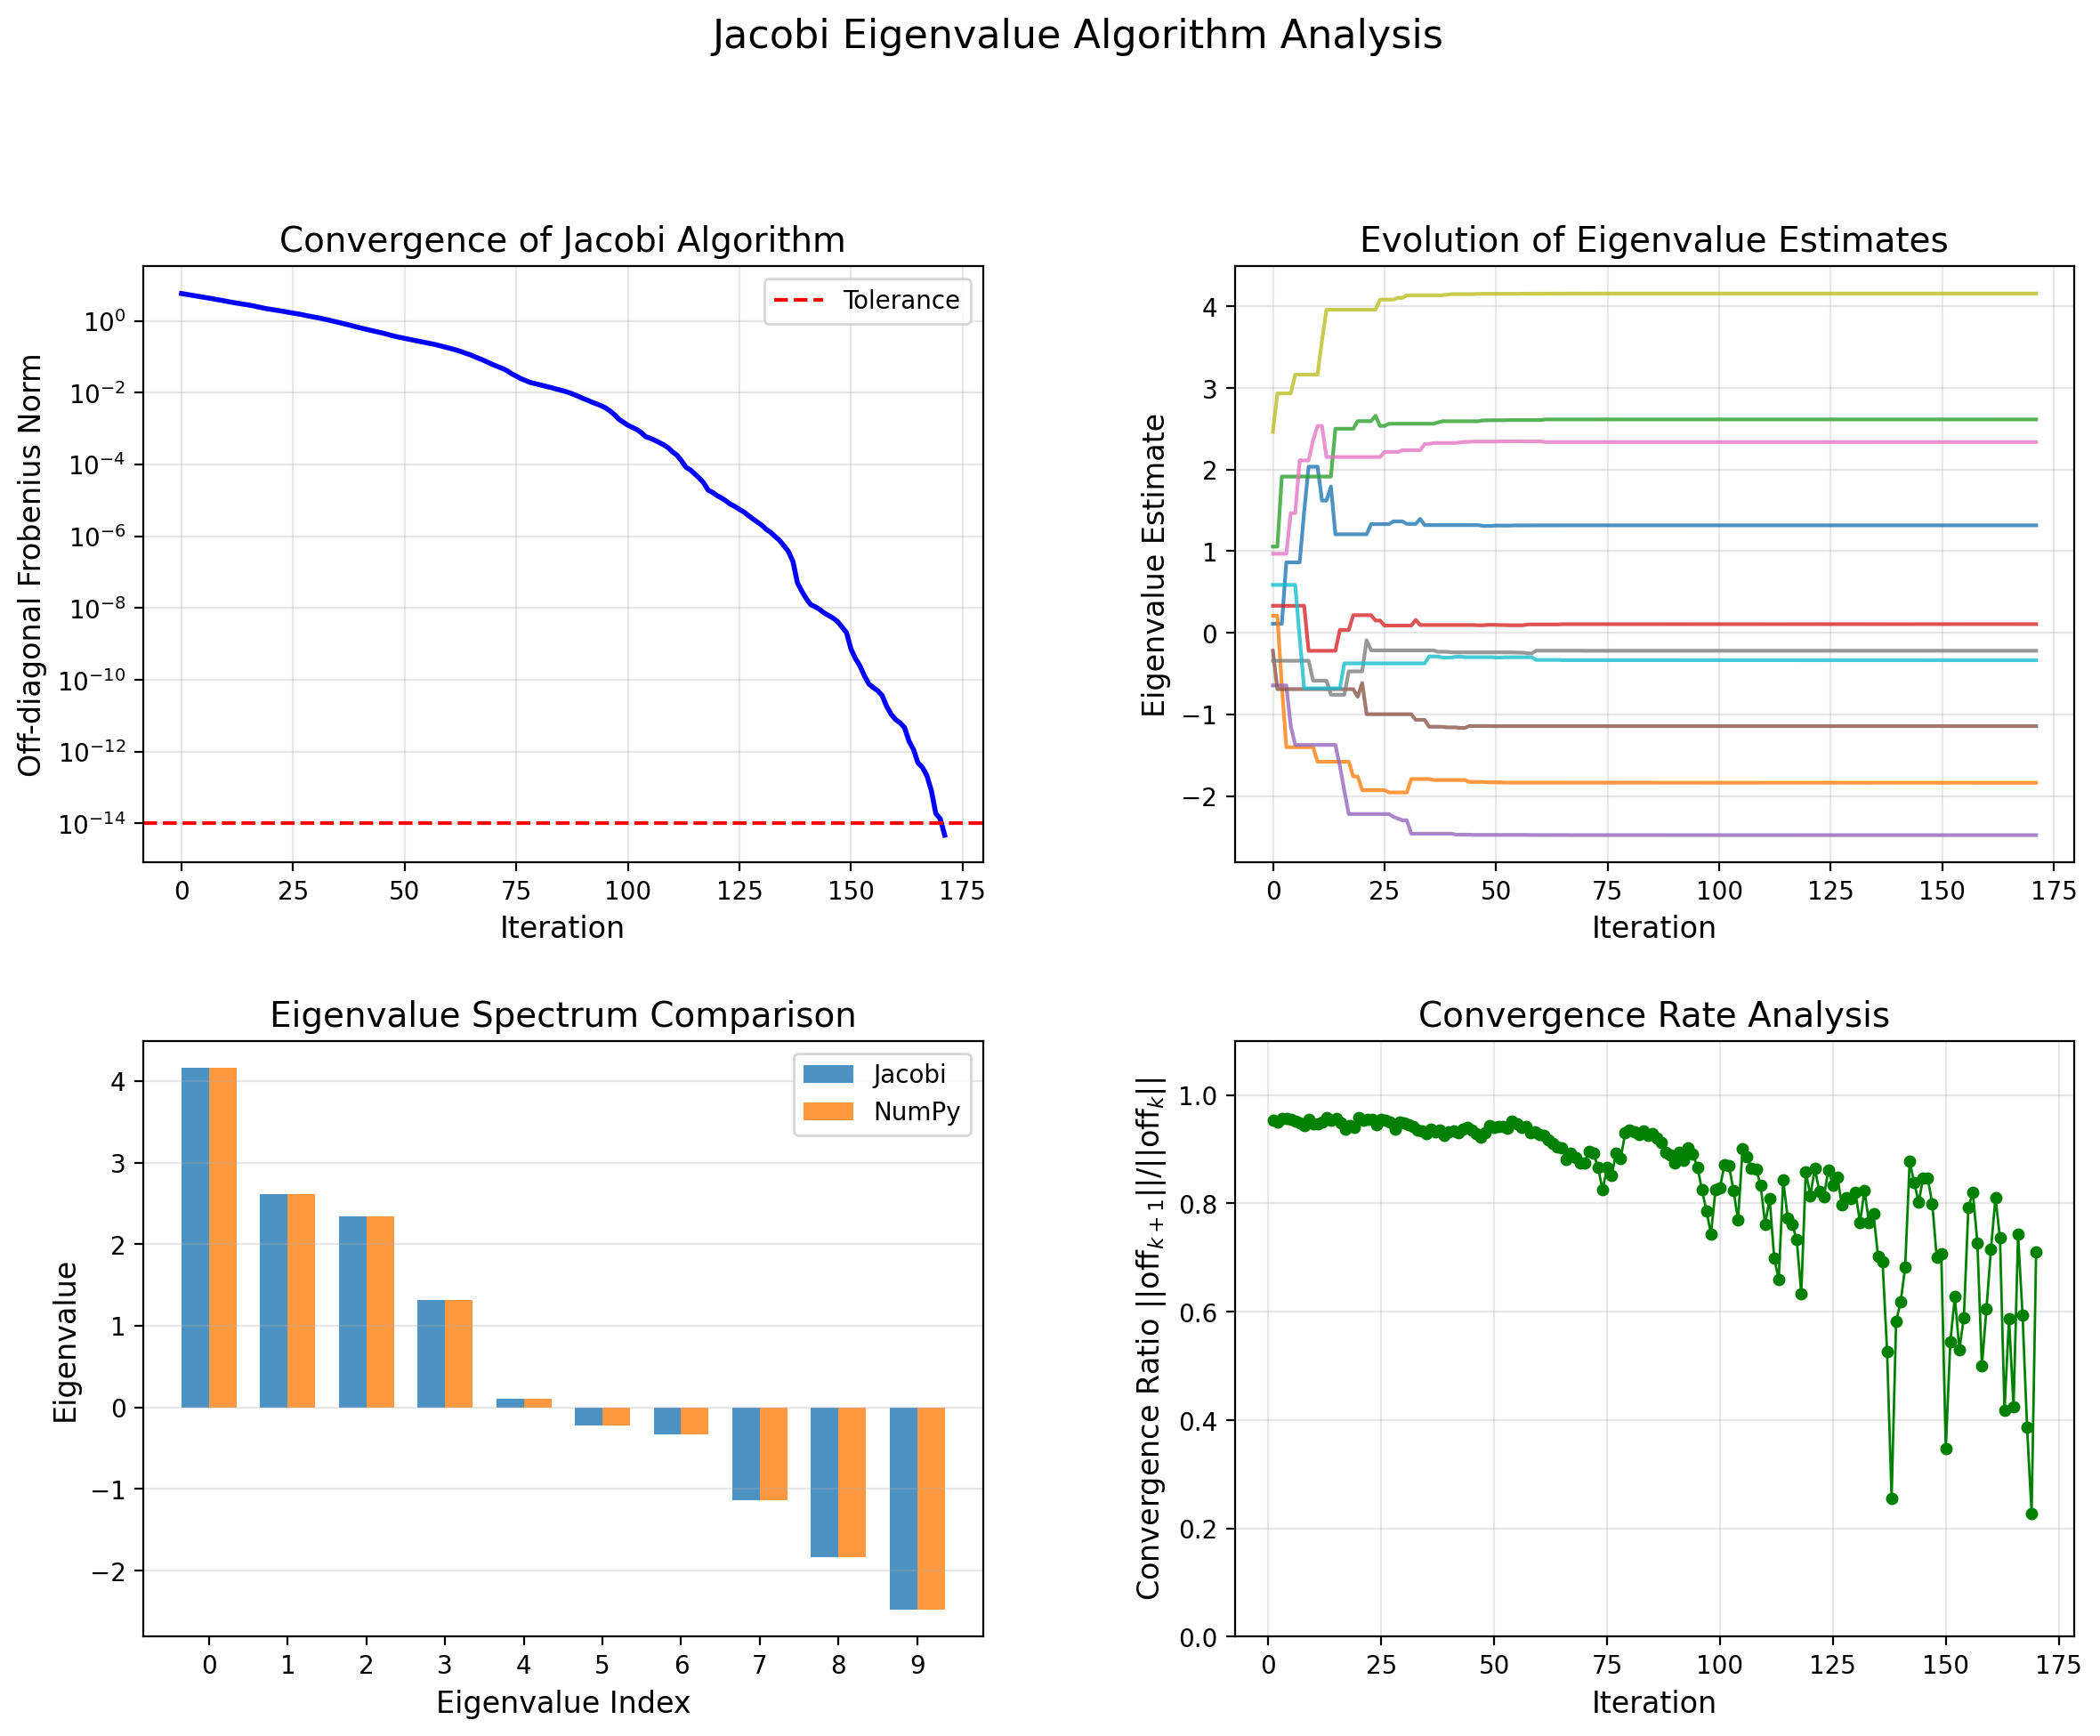


Plot saved to 'plot.png'


In [8]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

# Plot 1: Convergence of off-diagonal norm
ax1 = fig.add_subplot(gs[0, 0])
iterations = range(len(history_large['off_diagonal_norm']))
ax1.semilogy(iterations, history_large['off_diagonal_norm'], 'b-', linewidth=2)
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Off-diagonal Frobenius Norm', fontsize=12)
ax1.set_title('Convergence of Jacobi Algorithm', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1e-14, color='r', linestyle='--', label='Tolerance')
ax1.legend()

# Plot 2: Evolution of eigenvalue estimates
ax2 = fig.add_subplot(gs[0, 1])
eigenvalue_history = np.array(history_large['eigenvalue_estimates'])
for i in range(n_large):
    ax2.plot(iterations, eigenvalue_history[:, i], linewidth=1.5, alpha=0.8)
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Eigenvalue Estimate', fontsize=12)
ax2.set_title('Evolution of Eigenvalue Estimates', fontsize=14)
ax2.grid(True, alpha=0.3)

# Plot 3: Eigenvalue spectrum comparison
ax3 = fig.add_subplot(gs[1, 0])
x_pos = np.arange(n_large)
width = 0.35
np_eigs_large = np.sort(np.linalg.eigvalsh(A_large))[::-1]
bars1 = ax3.bar(x_pos - width/2, eigenvalues_large, width, label='Jacobi', alpha=0.8)
bars2 = ax3.bar(x_pos + width/2, np_eigs_large, width, label='NumPy', alpha=0.8)
ax3.set_xlabel('Eigenvalue Index', fontsize=12)
ax3.set_ylabel('Eigenvalue', fontsize=12)
ax3.set_title('Eigenvalue Spectrum Comparison', fontsize=14)
ax3.set_xticks(x_pos)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Convergence rate analysis
ax4 = fig.add_subplot(gs[1, 1])
off_norms = np.array(history_large['off_diagonal_norm'])
if len(off_norms) > 2:
    # Compute convergence ratios
    ratios = off_norms[1:-1] / off_norms[:-2]
    ax4.plot(range(1, len(ratios) + 1), ratios, 'go-', markersize=4, linewidth=1)
    ax4.set_xlabel('Iteration', fontsize=12)
    ax4.set_ylabel('Convergence Ratio $||\\text{off}_{k+1}|| / ||\\text{off}_k||$', fontsize=12)
    ax4.set_title('Convergence Rate Analysis', fontsize=14)
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim([0, 1.1])

plt.suptitle('Jacobi Eigenvalue Algorithm Analysis', fontsize=16, y=1.02)
plt.savefig('jacobi_eigenvalue_algorithm_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nPlot saved to 'plot.png'")

## Complexity Analysis

The Jacobi algorithm has the following computational characteristics:

- **Per-iteration cost**: $O(n)$ for updating rows/columns after a rotation
- **Finding maximum element**: $O(n^2)$ per iteration
- **Total iterations**: Typically $O(n^2)$ for convergence
- **Overall complexity**: $O(n^4)$ in the worst case

While slower than methods like QR iteration ($O(n^3)$), the Jacobi algorithm offers:
- Excellent numerical stability
- Natural parallelization (multiple independent rotations can be applied simultaneously)
- Guaranteed convergence for symmetric matrices

In [9]:
# Demonstrate scaling behavior
sizes = [5, 10, 15, 20, 25]
iteration_counts = []

for size in sizes:
    M = np.random.randn(size, size)
    A_test = (M + M.T) / 2
    _, _, hist = jacobi_eigenvalue(A_test, tol=1e-10)
    iteration_counts.append(hist['iterations'])
    print(f"n = {size:2d}: {hist['iterations']:4d} iterations")

print(f"\nIterations scale roughly as O(n²): ratio ≈ {iteration_counts[-1]/iteration_counts[0]:.1f} for n ratio of {sizes[-1]/sizes[0]:.1f}")

n =  5:   31 iterations
n = 10:  157 iterations
n = 15:  377 iterations
n = 20:  684 iterations


n = 25: 1000 iterations

Iterations scale roughly as O(n²): ratio ≈ 32.3 for n ratio of 5.0


## Conclusion

The Jacobi eigenvalue algorithm demonstrates several key principles:

1. **Orthogonal similarity transformations** preserve eigenvalues while transforming the matrix toward diagonal form

2. **Monotonic convergence** is guaranteed: each rotation reduces the off-diagonal norm

3. **Numerical stability** makes it suitable for high-precision applications

4. **Parallelization potential** through independent Jacobi rotations (not shown here)

Despite its $O(n^4)$ complexity, the Jacobi method remains relevant for small to medium-sized matrices where stability is paramount, and for parallel computing environments where its natural parallelism can be exploited.